# Business Analytics EDA: Time Series & Funnel Analysis

This notebook addresses the audit findings by providing:
1. **Time Series Analysis**: Daily/Monthly trends, seasonality patterns
2. **Conversion Funnel Analysis**: View → Cart → Transaction pipeline
3. **Purchaser vs Non-Purchaser Comparison**: Behavioral differences

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

# Color palette for consistency
COLORS = {
    'view': '#3498db',
    'addtocart': '#f39c12', 
    'transaction': '#27ae60',
    'primary': '#2c3e50',
    'secondary': '#95a5a6'
}

## 1. Data Loading & Preparation

In [2]:
# Load events data
events = pd.read_csv('../dataset/events.csv')

# Convert timestamp to datetime
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms', utc=True)
events['date'] = events['datetime'].dt.date
events['hour'] = events['datetime'].dt.hour
events['day_of_week'] = events['datetime'].dt.day_name()
events['week'] = events['datetime'].dt.isocalendar().week
events['month'] = events['datetime'].dt.month

print(f"Dataset Shape: {events.shape}")
print(f"Date Range: {events['date'].min()} to {events['date'].max()}")
print(f"Unique Visitors: {events['visitorid'].nunique():,}")
print(f"Unique Items: {events['itemid'].nunique():,}")

Dataset Shape: (2756101, 11)
Date Range: 2015-05-03 to 2015-09-18
Unique Visitors: 1,407,580
Unique Items: 235,061


---

# Part 1: Time Series Analysis

Understanding temporal patterns is crucial for:
- **Campaign Timing**: When to launch promotions
- **Resource Allocation**: Staffing and server capacity
- **Trend Detection**: Growth or decline signals

## 1.1 Daily Active Users (DAU) Trend

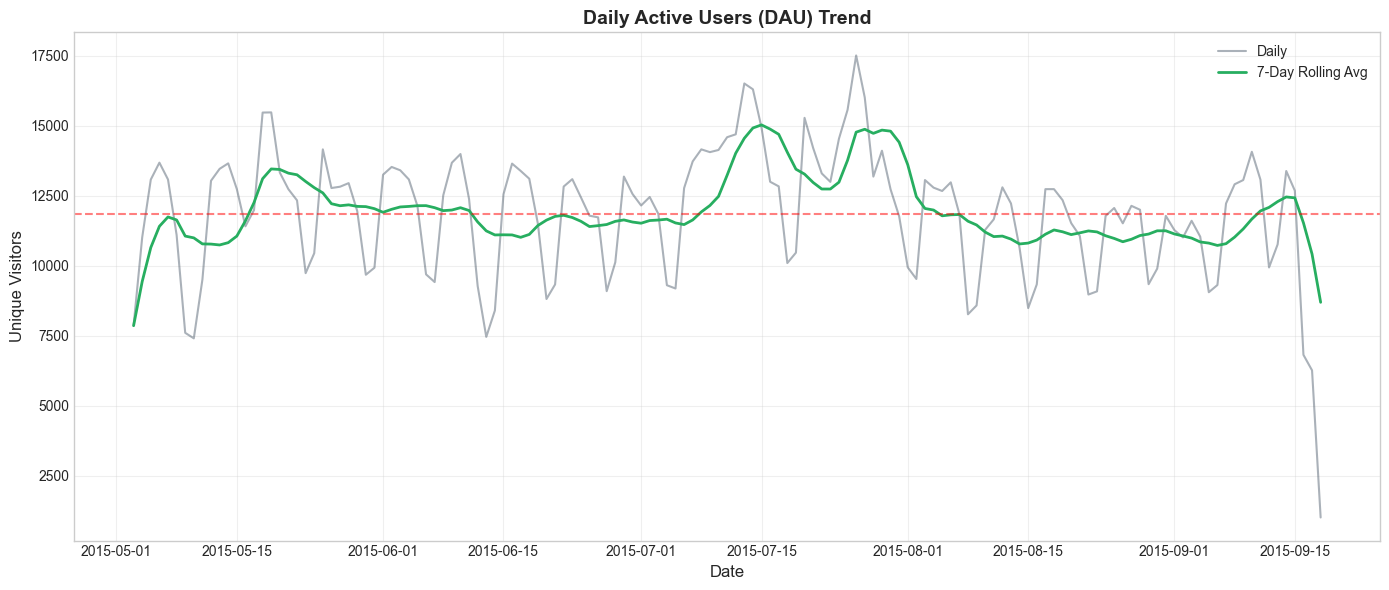


📊 DAU Statistics:
   Average: 11,867 visitors/day
   Max: 17,516 visitors
   Min: 1,016 visitors


In [3]:
# Calculate Daily Active Users
daily_users = events.groupby('date')['visitorid'].nunique().reset_index()
daily_users.columns = ['date', 'unique_visitors']
daily_users['date'] = pd.to_datetime(daily_users['date'])

# Calculate 7-day rolling average
daily_users['rolling_7d'] = daily_users['unique_visitors'].rolling(window=7, min_periods=1).mean()

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(daily_users['date'], daily_users['unique_visitors'], 
        alpha=0.4, color=COLORS['primary'], label='Daily')
ax.plot(daily_users['date'], daily_users['rolling_7d'], 
        color=COLORS['transaction'], linewidth=2, label='7-Day Rolling Avg')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Unique Visitors', fontsize=12)
ax.set_title('Daily Active Users (DAU) Trend', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add summary stats
avg_dau = daily_users['unique_visitors'].mean()
ax.axhline(y=avg_dau, color='red', linestyle='--', alpha=0.5, label=f'Avg: {avg_dau:,.0f}')

plt.tight_layout()
plt.show()

print(f"\n📊 DAU Statistics:")
print(f"   Average: {avg_dau:,.0f} visitors/day")
print(f"   Max: {daily_users['unique_visitors'].max():,} visitors")
print(f"   Min: {daily_users['unique_visitors'].min():,} visitors")

## 1.2 Daily Events by Type

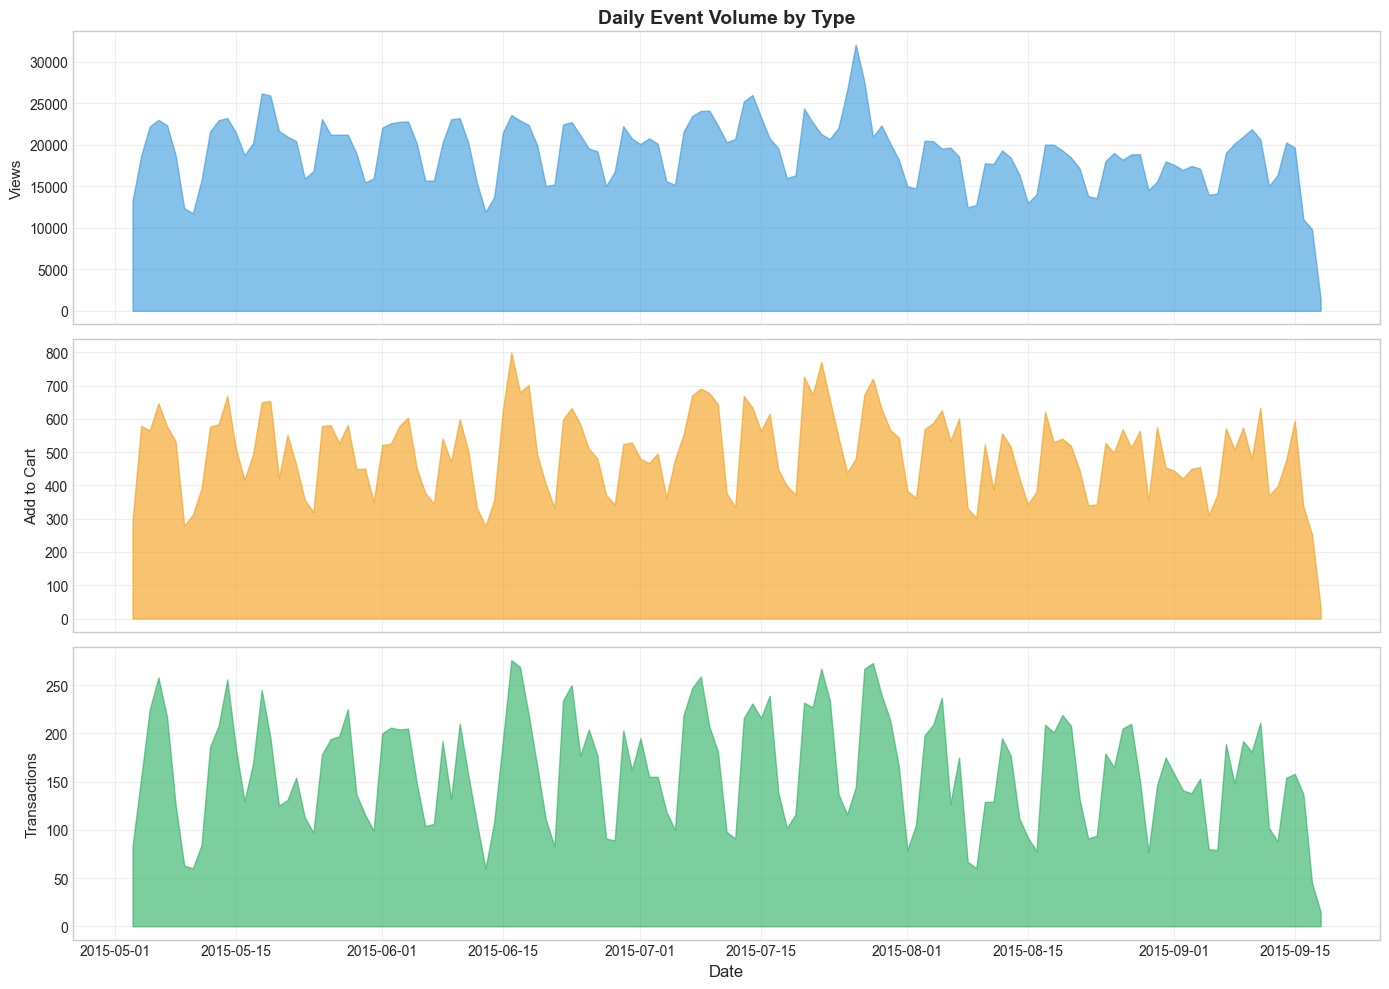

In [4]:
# Daily events breakdown
daily_events = events.groupby(['date', 'event']).size().unstack(fill_value=0).reset_index()
daily_events['date'] = pd.to_datetime(daily_events['date'])

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Views
axes[0].fill_between(daily_events['date'], daily_events['view'], 
                     alpha=0.6, color=COLORS['view'])
axes[0].set_ylabel('Views', fontsize=11)
axes[0].set_title('Daily Event Volume by Type', fontsize=14, fontweight='bold')

# Add to Cart
axes[1].fill_between(daily_events['date'], daily_events['addtocart'], 
                     alpha=0.6, color=COLORS['addtocart'])
axes[1].set_ylabel('Add to Cart', fontsize=11)

# Transactions
axes[2].fill_between(daily_events['date'], daily_events['transaction'], 
                     alpha=0.6, color=COLORS['transaction'])
axes[2].set_ylabel('Transactions', fontsize=11)
axes[2].set_xlabel('Date', fontsize=12)

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.3 Day of Week Patterns (Seasonality)

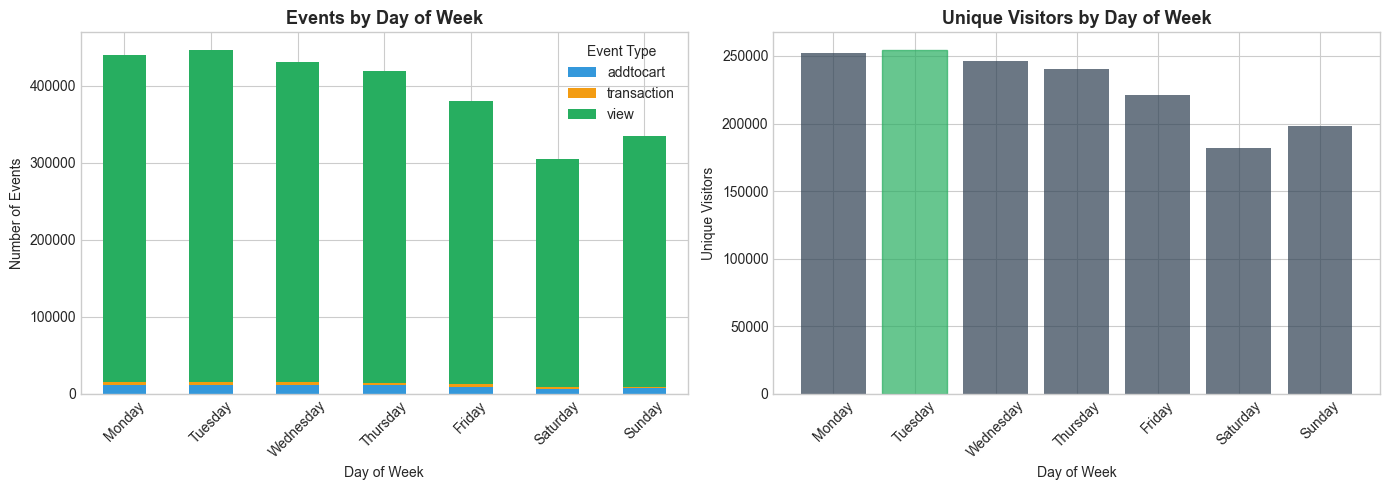


📅 Day of Week Insights:
   Best Day: Tuesday (254,742 visitors)
   Lowest Day: Saturday (182,054 visitors)


In [ ]:
# Order days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Events by day of week
dow_events = events.groupby(['day_of_week', 'event']).size().unstack(fill_value=0)
dow_events = dow_events.reindex(day_order)

# Unique visitors by day of week
dow_visitors = events.groupby('day_of_week')['visitorid'].nunique()
dow_visitors = dow_visitors.reindex(day_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stacked bar chart of events
dow_events.plot(kind='bar', stacked=True, ax=axes[0], 
                color=[COLORS['view'], COLORS['addtocart'], COLORS['transaction']])
axes[0].set_title('Events by Day of Week', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Events')
axes[0].legend(title='Event Type')
axes[0].tick_params(axis='x', rotation=45)

# Right: Unique visitors
bars = axes[1].bar(dow_visitors.index, dow_visitors.values, color=COLORS['primary'], alpha=0.7)
axes[1].set_title('Unique Visitors by Day of Week', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Unique Visitors')
axes[1].tick_params(axis='x', rotation=45)

# Highlight best day
max_idx = dow_visitors.values.argmax()
bars[max_idx].set_color(COLORS['transaction'])

plt.tight_layout()
plt.show()
y.scale('log')
print(f"\n📅 Day of Week Insights:")
print(f"   Best Day: {dow_visitors.idxmax()} ({dow_visitors.max():,} visitors)")
print(f"   Lowest Day: {dow_visitors.idxmin()} ({dow_visitors.min():,} visitors)")

## 1.4 Hourly Activity Patterns

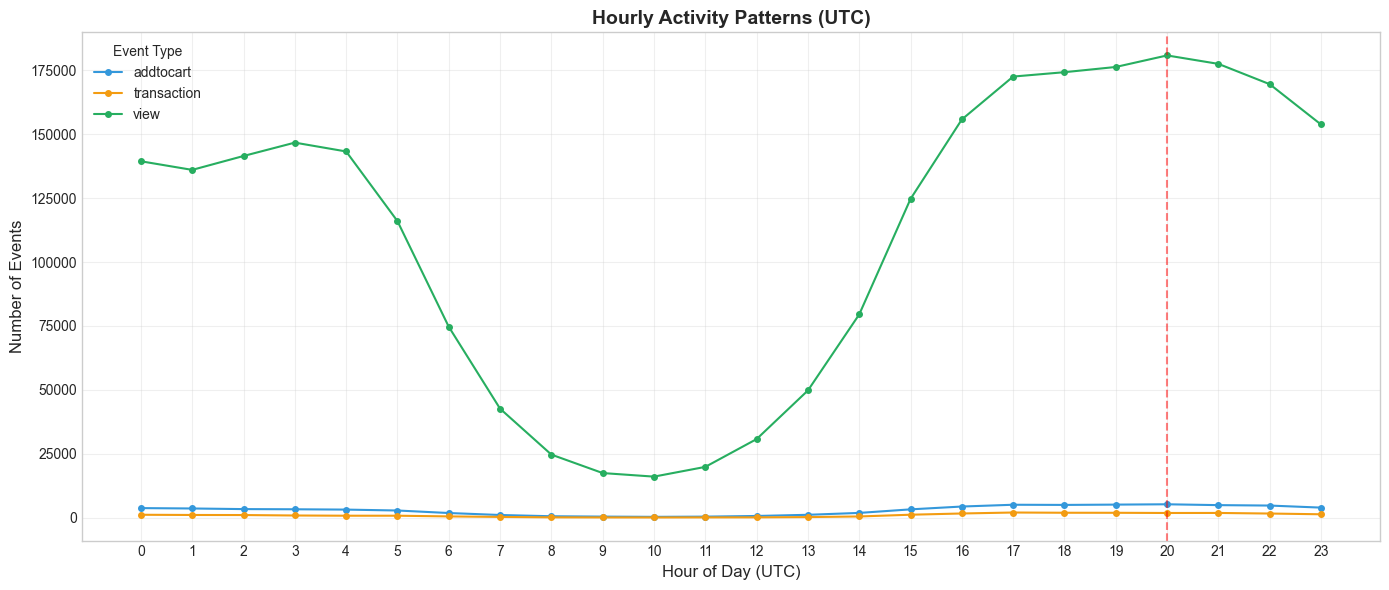


⏰ Peak Hour: 20:00 UTC


In [6]:
# Hourly patterns
hourly_events = events.groupby(['hour', 'event']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))

hourly_events.plot(kind='line', ax=ax, marker='o', markersize=4,
                   color=[COLORS['view'], COLORS['addtocart'], COLORS['transaction']])

ax.set_title('Hourly Activity Patterns (UTC)', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day (UTC)', fontsize=12)
ax.set_ylabel('Number of Events', fontsize=12)
ax.set_xticks(range(24))
ax.legend(title='Event Type')
ax.grid(True, alpha=0.3)

# Highlight peak hours
peak_hour = hourly_events.sum(axis=1).idxmax()
ax.axvline(x=peak_hour, color='red', linestyle='--', alpha=0.5, label=f'Peak: {peak_hour}:00')

plt.tight_layout()
plt.show()

print(f"\n⏰ Peak Hour: {peak_hour}:00 UTC")

## 1.5 Weekly Transaction Trends

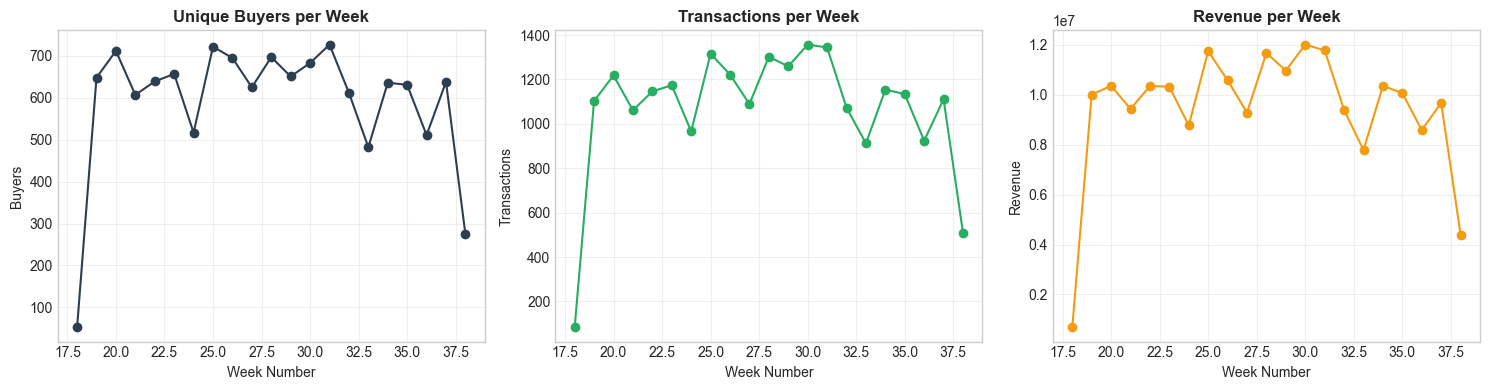

In [7]:
# Weekly aggregation
transactions = events[events['event'] == 'transaction'].copy()
transactions['transaction_value'] = transactions['transactionid']

weekly_stats = transactions.groupby('week').agg({
    'visitorid': 'nunique',
    'transactionid': 'count',
    'transaction_value': 'sum'
}).reset_index()
weekly_stats.columns = ['week', 'unique_buyers', 'num_transactions', 'total_revenue']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Unique Buyers
axes[0].plot(weekly_stats['week'], weekly_stats['unique_buyers'], 
             marker='o', color=COLORS['primary'])
axes[0].set_title('Unique Buyers per Week', fontweight='bold')
axes[0].set_xlabel('Week Number')
axes[0].set_ylabel('Buyers')

# Transaction Count
axes[1].plot(weekly_stats['week'], weekly_stats['num_transactions'], 
             marker='o', color=COLORS['transaction'])
axes[1].set_title('Transactions per Week', fontweight='bold')
axes[1].set_xlabel('Week Number')
axes[1].set_ylabel('Transactions')

# Revenue
axes[2].plot(weekly_stats['week'], weekly_stats['total_revenue'], 
             marker='o', color=COLORS['addtocart'])
axes[2].set_title('Revenue per Week', fontweight='bold')
axes[2].set_xlabel('Week Number')
axes[2].set_ylabel('Revenue')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# Part 2: Conversion Funnel Analysis

The conversion funnel is the most critical metric for e-commerce:
- **View** → Browse products
- **Add to Cart** → Purchase intent
- **Transaction** → Revenue generation

## 2.1 Overall Funnel Metrics

In [8]:
# Calculate funnel metrics (visitor-level)
total_visitors = events['visitorid'].nunique()
viewers = events[events['event']=='view']['visitorid'].nunique()
cart_adders = events[events['event']=='addtocart']['visitorid'].nunique()
purchasers = events[events['event']=='transaction']['visitorid'].nunique()

# Conversion rates
view_to_cart = (cart_adders / viewers) * 100
cart_to_purchase = (purchasers / cart_adders) * 100
overall_conversion = (purchasers / total_visitors) * 100

print("="*60)
print("CONVERSION FUNNEL SUMMARY")
print("="*60)
print(f"\n📊 Funnel Stages:")
print(f"   Stage 1 - Viewers:        {viewers:>12,} visitors")
print(f"   Stage 2 - Cart Adders:    {cart_adders:>12,} visitors")
print(f"   Stage 3 - Purchasers:     {purchasers:>12,} visitors")
print(f"\n📈 Conversion Rates:")
print(f"   View → Cart:              {view_to_cart:>12.2f}%")
print(f"   Cart → Purchase:          {cart_to_purchase:>12.2f}%")
print(f"   Overall (View → Purchase):{overall_conversion:>12.2f}%")

CONVERSION FUNNEL SUMMARY

📊 Funnel Stages:
   Stage 1 - Viewers:           1,404,179 visitors
   Stage 2 - Cart Adders:          37,722 visitors
   Stage 3 - Purchasers:           11,719 visitors

📈 Conversion Rates:
   View → Cart:                      2.69%
   Cart → Purchase:                 31.07%
   Overall (View → Purchase):        0.83%


## 2.2 Funnel Visualization

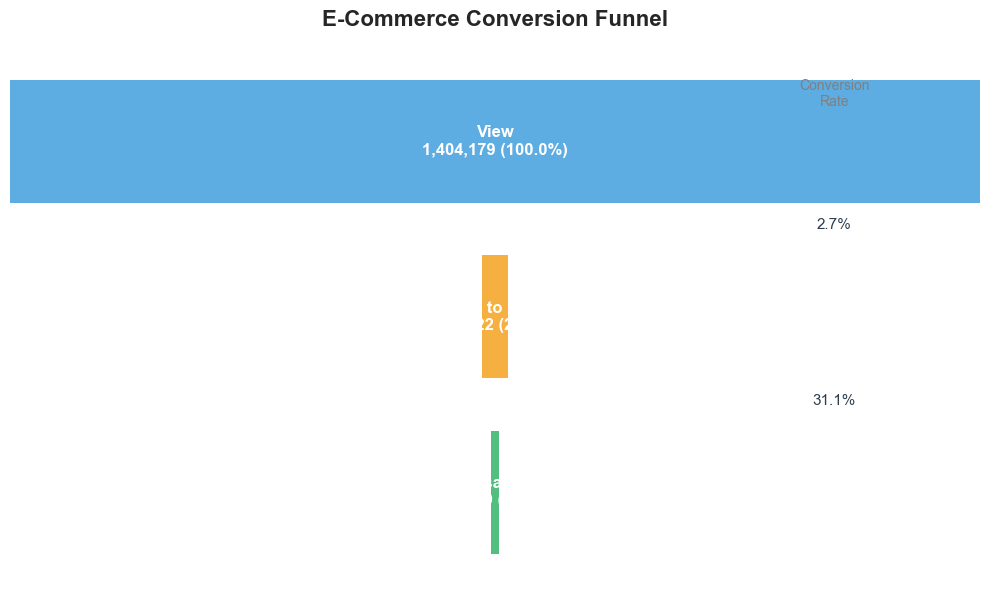

In [9]:
# Funnel data
funnel_data = {
    'Stage': ['View', 'Add to Cart', 'Transaction'],
    'Visitors': [viewers, cart_adders, purchasers],
    'Color': [COLORS['view'], COLORS['addtocart'], COLORS['transaction']]
}
funnel_df = pd.DataFrame(funnel_data)
funnel_df['Percentage'] = (funnel_df['Visitors'] / funnel_df['Visitors'].iloc[0]) * 100

# Create funnel chart
fig, ax = plt.subplots(figsize=(10, 6))

# Draw funnel bars (horizontal, centered)
for i, row in funnel_df.iterrows():
    width = row['Percentage']
    left = (100 - width) / 2
    ax.barh(2-i, width, left=left, height=0.7, color=row['Color'], alpha=0.8)
    
    # Add labels
    ax.text(50, 2-i, f"{row['Stage']}\n{row['Visitors']:,} ({row['Percentage']:.1f}%)", 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')

ax.set_xlim(0, 100)
ax.set_ylim(-0.5, 2.5)
ax.set_title('E-Commerce Conversion Funnel', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

# Add conversion rate arrows
ax.annotate(f'{view_to_cart:.1f}%', xy=(85, 1.5), fontsize=11, 
            ha='center', color=COLORS['primary'])
ax.annotate(f'{cart_to_purchase:.1f}%', xy=(85, 0.5), fontsize=11, 
            ha='center', color=COLORS['primary'])
ax.text(85, 2.2, 'Conversion\nRate', ha='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

## 2.3 Funnel Trends Over Time

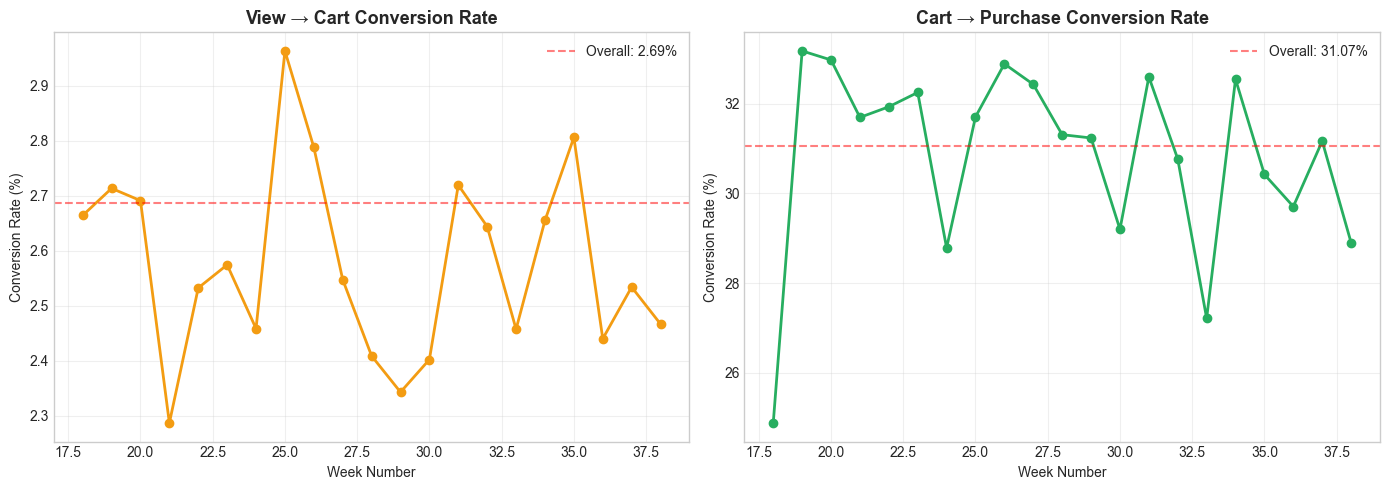

In [10]:
# Weekly funnel metrics
weekly_funnel = events.groupby(['week', 'event'])['visitorid'].nunique().unstack(fill_value=0)
weekly_funnel['view_to_cart'] = (weekly_funnel['addtocart'] / weekly_funnel['view']) * 100
weekly_funnel['cart_to_purchase'] = (weekly_funnel['transaction'] / weekly_funnel['addtocart']) * 100
weekly_funnel = weekly_funnel.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# View to Cart Conversion
axes[0].plot(weekly_funnel['week'], weekly_funnel['view_to_cart'], 
             marker='o', color=COLORS['addtocart'], linewidth=2)
axes[0].axhline(y=view_to_cart, color='red', linestyle='--', alpha=0.5, 
                label=f'Overall: {view_to_cart:.2f}%')
axes[0].set_title('View → Cart Conversion Rate', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Week Number')
axes[0].set_ylabel('Conversion Rate (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cart to Purchase Conversion
axes[1].plot(weekly_funnel['week'], weekly_funnel['cart_to_purchase'], 
             marker='o', color=COLORS['transaction'], linewidth=2)
axes[1].axhline(y=cart_to_purchase, color='red', linestyle='--', alpha=0.5, 
                label=f'Overall: {cart_to_purchase:.2f}%')
axes[1].set_title('Cart → Purchase Conversion Rate', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Week Number')
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# Part 3: Purchaser vs Non-Purchaser Analysis

Understanding the behavioral differences between converters and non-converters is key for:
- **Targeting**: Identifying high-potential visitors
- **Optimization**: Reducing friction in the funnel
- **Personalization**: Tailoring experiences by segment

## 3.1 Segment Definition

In [11]:
# Identify purchasers
purchaser_ids = events[events['event']=='transaction']['visitorid'].unique()

# Create segment labels
events['is_purchaser'] = events['visitorid'].isin(purchaser_ids)

# Aggregate behavior per visitor
visitor_behavior = events.groupby('visitorid').agg({
    'event': 'count',  # Total events
    'itemid': 'nunique',  # Unique items viewed
    'is_purchaser': 'first',  # Segment flag
    'date': ['min', 'max'],  # Activity period
}).reset_index()

visitor_behavior.columns = ['visitorid', 'total_events', 'unique_items', 'is_purchaser', 'first_visit', 'last_visit']

# Add event type counts
event_counts = events.pivot_table(index='visitorid', columns='event', aggfunc='size', fill_value=0)
visitor_behavior = visitor_behavior.merge(event_counts, on='visitorid', how='left')

print(f"Total Visitors: {len(visitor_behavior):,}")
print(f"Purchasers: {visitor_behavior['is_purchaser'].sum():,} ({visitor_behavior['is_purchaser'].mean()*100:.2f}%)")
print(f"Non-Purchasers: {(~visitor_behavior['is_purchaser']).sum():,}")

Total Visitors: 1,407,580
Purchasers: 11,719 (0.83%)
Non-Purchasers: 1,395,861


## 3.2 Behavioral Comparison

In [12]:
# Compare metrics
comparison = visitor_behavior.groupby('is_purchaser').agg({
    'total_events': 'mean',
    'unique_items': 'mean',
    'view': 'mean',
    'addtocart': 'mean',
    'transaction': 'mean'
}).round(2)

comparison.index = ['Non-Purchaser', 'Purchaser']
comparison.columns = ['Avg Events', 'Avg Unique Items', 'Avg Views', 'Avg Cart Adds', 'Avg Transactions']

print("\n📊 Behavioral Comparison:")
print(comparison.T.to_string())


📊 Behavioral Comparison:
                  Non-Purchaser  Purchaser
Avg Events                 1.81      19.68
Avg Unique Items           1.46       9.54
Avg Views                  1.78      15.42
Avg Cart Adds              0.03       2.34
Avg Transactions           0.00       1.92


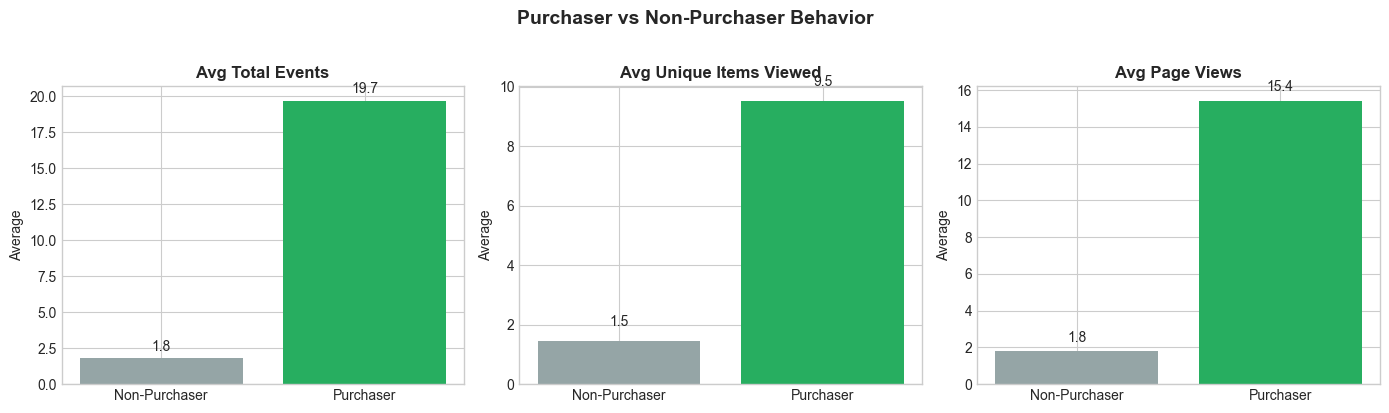

In [13]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics = ['total_events', 'unique_items', 'view']
titles = ['Avg Total Events', 'Avg Unique Items Viewed', 'Avg Page Views']

for ax, metric, title in zip(axes, metrics, titles):
    data = visitor_behavior.groupby('is_purchaser')[metric].mean()
    bars = ax.bar(['Non-Purchaser', 'Purchaser'], data.values, 
                  color=[COLORS['secondary'], COLORS['transaction']])
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Average')
    
    # Add value labels
    for bar, val in zip(bars, data.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}', ha='center', fontsize=10)

plt.suptitle('Purchaser vs Non-Purchaser Behavior', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3.3 Cart Abandonment Analysis

CART ABANDONMENT ANALYSIS

Total Cart Users: 37,722
Converted to Purchase: 10,576
Abandoned Cart: 27,146

🛒 Cart Abandonment Rate: 72.0%


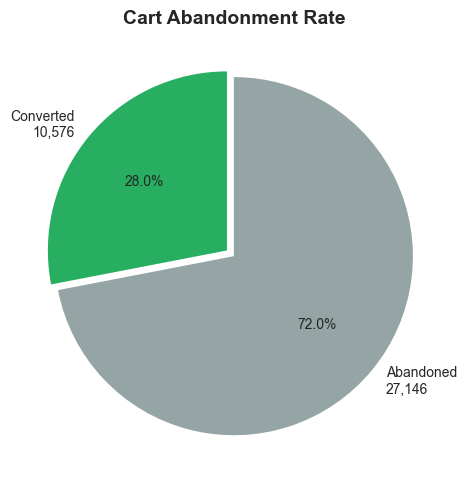

In [14]:
# Visitors who added to cart
cart_users = events[events['event']=='addtocart']['visitorid'].unique()

# Cart abandoners: added to cart but never purchased
cart_abandoners = set(cart_users) - set(purchaser_ids)

abandonment_rate = len(cart_abandoners) / len(cart_users) * 100

print("="*50)
print("CART ABANDONMENT ANALYSIS")
print("="*50)
print(f"\nTotal Cart Users: {len(cart_users):,}")
print(f"Converted to Purchase: {len(cart_users) - len(cart_abandoners):,}")
print(f"Abandoned Cart: {len(cart_abandoners):,}")
print(f"\n🛒 Cart Abandonment Rate: {abandonment_rate:.1f}%")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
sizes = [len(cart_users) - len(cart_abandoners), len(cart_abandoners)]
labels = [f'Converted\n{sizes[0]:,}', f'Abandoned\n{sizes[1]:,}']
colors = [COLORS['transaction'], COLORS['secondary']]

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                   startangle=90, explode=[0.05, 0])
ax.set_title('Cart Abandonment Rate', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

# Part 4: Summary & Business Insights

In [15]:
print("="*70)
print("KEY BUSINESS INSIGHTS SUMMARY")
print("="*70)

print("\n📈 TIME SERIES INSIGHTS:")
print(f"   • Average Daily Active Users: {avg_dau:,.0f}")
print(f"   • Peak Day of Week: {dow_visitors.idxmax()}")
print(f"   • Peak Hour (UTC): {peak_hour}:00")

print("\n🎯 CONVERSION FUNNEL:")
print(f"   • View → Cart Rate: {view_to_cart:.2f}%")
print(f"   • Cart → Purchase Rate: {cart_to_purchase:.2f}%")
print(f"   • Overall Conversion: {overall_conversion:.2f}%")
print(f"   • Cart Abandonment: {abandonment_rate:.1f}%")

print("\n👥 PURCHASER BEHAVIOR:")
purchaser_avg = visitor_behavior[visitor_behavior['is_purchaser']]['total_events'].mean()
non_purchaser_avg = visitor_behavior[~visitor_behavior['is_purchaser']]['total_events'].mean()
print(f"   • Purchasers avg {purchaser_avg:.1f} events vs Non-purchasers avg {non_purchaser_avg:.1f} events")
print(f"   • Purchasers are {purchaser_avg/non_purchaser_avg:.1f}x more engaged")

print("\n💡 RECOMMENDATIONS:")
print(f"   1. Focus marketing campaigns on {dow_visitors.idxmax()}s (peak traffic)")
print(f"   2. Implement cart abandonment recovery (target {len(cart_abandoners):,} users)")
print(f"   3. Increase engagement for low-activity visitors to boost conversion")

KEY BUSINESS INSIGHTS SUMMARY

📈 TIME SERIES INSIGHTS:
   • Average Daily Active Users: 11,867
   • Peak Day of Week: Tuesday
   • Peak Hour (UTC): 20:00

🎯 CONVERSION FUNNEL:
   • View → Cart Rate: 2.69%
   • Cart → Purchase Rate: 31.07%
   • Overall Conversion: 0.83%
   • Cart Abandonment: 72.0%

👥 PURCHASER BEHAVIOR:
   • Purchasers avg 19.7 events vs Non-purchasers avg 1.8 events
   • Purchasers are 10.9x more engaged

💡 RECOMMENDATIONS:
   1. Focus marketing campaigns on Tuesdays (peak traffic)
   2. Implement cart abandonment recovery (target 27,146 users)
   3. Increase engagement for low-activity visitors to boost conversion
